# Classification of Graphs using Vision Transformer trained from scratch

## Fetch Data

mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


checking whether a file exists

In [2]:
import os
file_path = "/content/drive/MyDrive/charts/train_val.csv"
print(os.path.exists(file_path))

True


read the csv file into a dataframe

In [3]:
import pandas as pd
df = pd.read_csv(file_path)
df.head()

,image_index,type
0,0,vbar_categorical
1,1,vbar_categorical
2,2,vbar_categorical
3,3,vbar_categorical
4,4,vbar_categorical


check for the unique labels in the dataframe

In [4]:
df.type.unique()

array(['vbar_categorical', 'hbar_categorical', 'line', 'pie', 'dot_line'],
      dtype=object)

fetching the training data

In [5]:
train_dir = "/content/drive/MyDrive/charts/train_val"

import os
train_paths = os.listdir(train_dir)
print(len(train_paths))

1000


storing the images and the labels into an array

In [6]:
import numpy as np
import cv2
def sort_data(dir, data, df):
    images = []
    labels = []
    for i in range(len(data)):
        img = cv2.imread(os.path.join(dir, data[i]))    # reading the images from the directory
        index = int(data[i].split(".")[0])
        label = df.loc[index, 'type']                   # fetching the associated labels
        labels.append(label)
        images.append(img)
    return np.array(images), np.array(labels)

X_train, Y_train = sort_data(train_dir, train_paths, df)

print(X_train.shape)
print(Y_train.shape)

(1000, 128, 128, 3)
(1000,)


1000 samples can be divide the into 800 for training and 200 for validation

spliting the dataset into validation and training

In [7]:
from sklearn.model_selection import train_test_split
 
x_train, x_validation, y_train, y_validation = train_test_split(
    X_train, 
    Y_train, 
    test_size=200, 
    shuffle=True,
    random_state=42,
    stratify=Y_train
)

print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(800, 128, 128, 3)
(800,)
(200, 128, 128, 3)
(200,)


checking the distribution among all the labels

In [8]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_validation, return_counts=True))

(array(['dot_line', 'hbar_categorical', 'line', 'pie', 'vbar_categorical'],
      dtype='<U16'), array([160, 160, 160, 160, 160]))
(array(['dot_line', 'hbar_categorical', 'line', 'pie', 'vbar_categorical'],
      dtype='<U16'), array([40, 40, 40, 40, 40]))


integer encoding

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_validation_enc = le.transform(y_validation)

print(np.unique(y_train_enc, return_counts=True))
print(np.unique(y_validation_enc, return_counts=True))

(array([0, 1, 2, 3, 4]), array([160, 160, 160, 160, 160]))
(array([0, 1, 2, 3, 4]), array([40, 40, 40, 40, 40]))


### Visualize random training data along with encodings

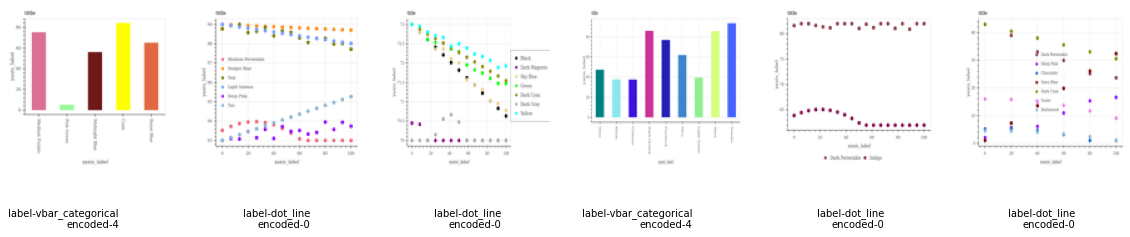

In [10]:
import matplotlib.pyplot as plt
import cv2
n = np.random.randint(0, 800, 6)
plt.figure(figsize=(20, 4))
for i in range(1, len(n)+1): 
    ax = plt.subplot(1, len(n), i)
    img = x_train[n[i-1]]
    plt.imshow(img)
    ax.text(0.7, -0.4, "label-{0}\nencoded-{1}".format(y_train[n[i-1]], y_train_enc[n[i-1]]),
    verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes, fontsize=10)
    plt.axis("off")
plt.show()

installing aditional library wherein tensorflow transformer implementation is there

In [12]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.8 MB/s 


Ignore warnings

In [13]:
import warnings
warnings.filterwarnings('ignore')

## Build Model layers and Model

Model parameters are initialised in one section

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

input_shape = (128, 128, 3)
num_classes = 5

learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 64
num_epochs = 30
image_size = 128  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 512
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

Normalising and resizing the data

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Implementing MLP

In [16]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Patch creation Layer

In [17]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Display the patches

Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


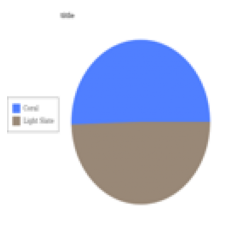

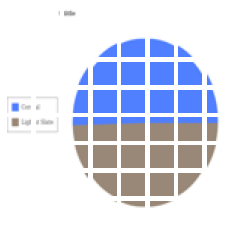

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image/255)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)


patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy()/255)
    plt.axis("off")

Patch encoding

In [19]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Model Creation and Training

In [20]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [21]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )

    checkpoint_filepath = '/content/drive/MyDrive/charts/model/vit/vit_epoch-{epoch:02d}_val_loss-{val_loss:.4f}'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="val_loss",
    mode="auto",
    save_best_only=True)

    history = model.fit(
        x_train, y_train_enc,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_validation, y_validation_enc),
        callbacks=[model_checkpoint_callback]
    )

    return history, model


vit_classifier = create_vit_classifier()
history, model = run_experiment(vit_classifier)

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.9808 - sparse_categorical_accuracy: 0.5500

INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-01_val_loss-0.6769/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-01_val_loss-0.6769/assets


13/13 [==============================] - 40s 2s/step - loss: 1.9808 - sparse_categorical_accuracy: 0.5500 - val_loss: 0.6769 - val_sparse_categorical_accuracy: 0.7950
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.8004 - sparse_categorical_accuracy: 0.8062

INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-02_val_loss-0.3984/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-02_val_loss-0.3984/assets


13/13 [==============================] - 33s 3s/step - loss: 0.8004 - sparse_categorical_accuracy: 0.8062 - val_loss: 0.3984 - val_sparse_categorical_accuracy: 0.8100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.8626 - sparse_categorical_accuracy: 0.7912

INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-03_val_loss-0.2659/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-03_val_loss-0.2659/assets


13/13 [==============================] - 30s 2s/step - loss: 0.8626 - sparse_categorical_accuracy: 0.7912 - val_loss: 0.2659 - val_sparse_categorical_accuracy: 0.8050
Epoch 4/30
13/13 [==============================] - 6s 475ms/step - loss: 0.8851 - sparse_categorical_accuracy: 0.8087 - val_loss: 1.3925 - val_sparse_categorical_accuracy: 0.8000
Epoch 5/30
13/13 [==============================] - 6s 482ms/step - loss: 0.8922 - sparse_categorical_accuracy: 0.8138 - val_loss: 0.2725 - val_sparse_categorical_accuracy: 0.8450
Epoch 6/30
13/13 [==============================] - ETA: 0s - loss: 0.5095 - sparse_categorical_accuracy: 0.8363

INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-06_val_loss-0.2560/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-06_val_loss-0.2560/assets


13/13 [==============================] - 26s 2s/step - loss: 0.5095 - sparse_categorical_accuracy: 0.8363 - val_loss: 0.2560 - val_sparse_categorical_accuracy: 0.8500
Epoch 7/30
13/13 [==============================] - 6s 489ms/step - loss: 0.5243 - sparse_categorical_accuracy: 0.8400 - val_loss: 0.2820 - val_sparse_categorical_accuracy: 0.8300
Epoch 8/30
13/13 [==============================] - 7s 503ms/step - loss: 0.3884 - sparse_categorical_accuracy: 0.8700 - val_loss: 0.7815 - val_sparse_categorical_accuracy: 0.8250
Epoch 9/30
13/13 [==============================] - ETA: 0s - loss: 0.5014 - sparse_categorical_accuracy: 0.8462

INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-09_val_loss-0.2233/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-09_val_loss-0.2233/assets


13/13 [==============================] - 26s 2s/step - loss: 0.5014 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.2233 - val_sparse_categorical_accuracy: 0.9150
Epoch 10/30
13/13 [==============================] - ETA: 0s - loss: 0.2425 - sparse_categorical_accuracy: 0.9187

INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-10_val_loss-0.1676/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-10_val_loss-0.1676/assets


13/13 [==============================] - 31s 3s/step - loss: 0.2425 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.1676 - val_sparse_categorical_accuracy: 0.9150
Epoch 11/30
13/13 [==============================] - 7s 504ms/step - loss: 0.2406 - sparse_categorical_accuracy: 0.9300 - val_loss: 0.2588 - val_sparse_categorical_accuracy: 0.9150
Epoch 12/30
13/13 [==============================] - 7s 518ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.3201 - val_sparse_categorical_accuracy: 0.9150
Epoch 13/30
13/13 [==============================] - 7s 523ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.3204 - val_sparse_categorical_accuracy: 0.9300
Epoch 14/30
13/13 [==============================] - 7s 519ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.2477 - val_sparse_categorical_accuracy: 0.9600
Epoch 15/30
13/13 [==============================] - ETA: 0s - loss: 0.0843 - sparse_categorical_accuracy: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-15_val_loss-0.1461/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-15_val_loss-0.1461/assets


13/13 [==============================] - 28s 2s/step - loss: 0.0843 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.1461 - val_sparse_categorical_accuracy: 0.9550
Epoch 16/30
13/13 [==============================] - 6s 484ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.1679 - val_sparse_categorical_accuracy: 0.9500
Epoch 17/30
13/13 [==============================] - ETA: 0s - loss: 0.0347 - sparse_categorical_accuracy: 0.9887

INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-17_val_loss-0.0789/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/charts/model/vit/vit_epoch-17_val_loss-0.0789/assets


13/13 [==============================] - 28s 2s/step - loss: 0.0347 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.0789 - val_sparse_categorical_accuracy: 0.9700
Epoch 18/30
13/13 [==============================] - 6s 499ms/step - loss: 0.0343 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.2334 - val_sparse_categorical_accuracy: 0.9600
Epoch 19/30
13/13 [==============================] - 7s 512ms/step - loss: 0.0376 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.2851 - val_sparse_categorical_accuracy: 0.9750
Epoch 20/30
13/13 [==============================] - 7s 518ms/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.1831 - val_sparse_categorical_accuracy: 0.9500
Epoch 21/30
13/13 [==============================] - 7s 523ms/step - loss: 0.0559 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.1368 - val_sparse_categorical_accuracy: 0.9500
Epoch 22/30
13/13 [==============================] - 7s 518ms/step - loss: 0.0140 - sparse_categorical_accura

### Visualize training and validation, loss and Accuracy

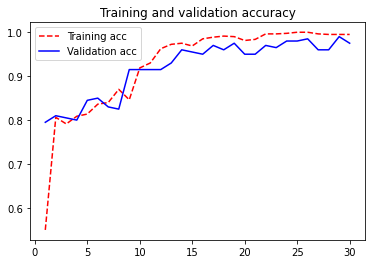

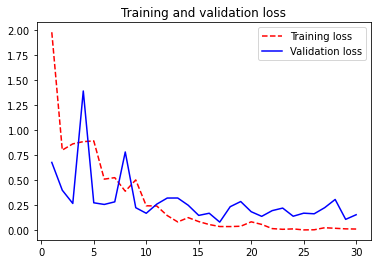

In [22]:
def plot_accuracy_and_loss(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '--r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, '--r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_accuracy_and_loss(history)

## predictions by the model on unlabelled test data

Loading the best model with Validation Accuracy 0.0789

In [23]:
model = tf.keras.models.load_model("/content/drive/MyDrive/charts/model/vit/vit_epoch-17_val_loss-0.0789")

reading the test data for model predictions

In [24]:
test_dir = "/content/drive/MyDrive/charts/test"
test_imgs = os.listdir(test_dir)

x_test = []
for img in test_imgs:
    im = cv2.imread(os.path.join(test_dir, img))
    x_test.append(im)
x_test = np.array(x_test)
print(x_test.shape)

(50, 128, 128, 3)


enum class helps when we to the prediction to see the associated label against each predicted integer

In [25]:
from enum import Enum
class Number(Enum):
    dot_line = 0
    hbar = 1
    line = 2
    pie = 3
    vbar = 4

Prediction on Test data

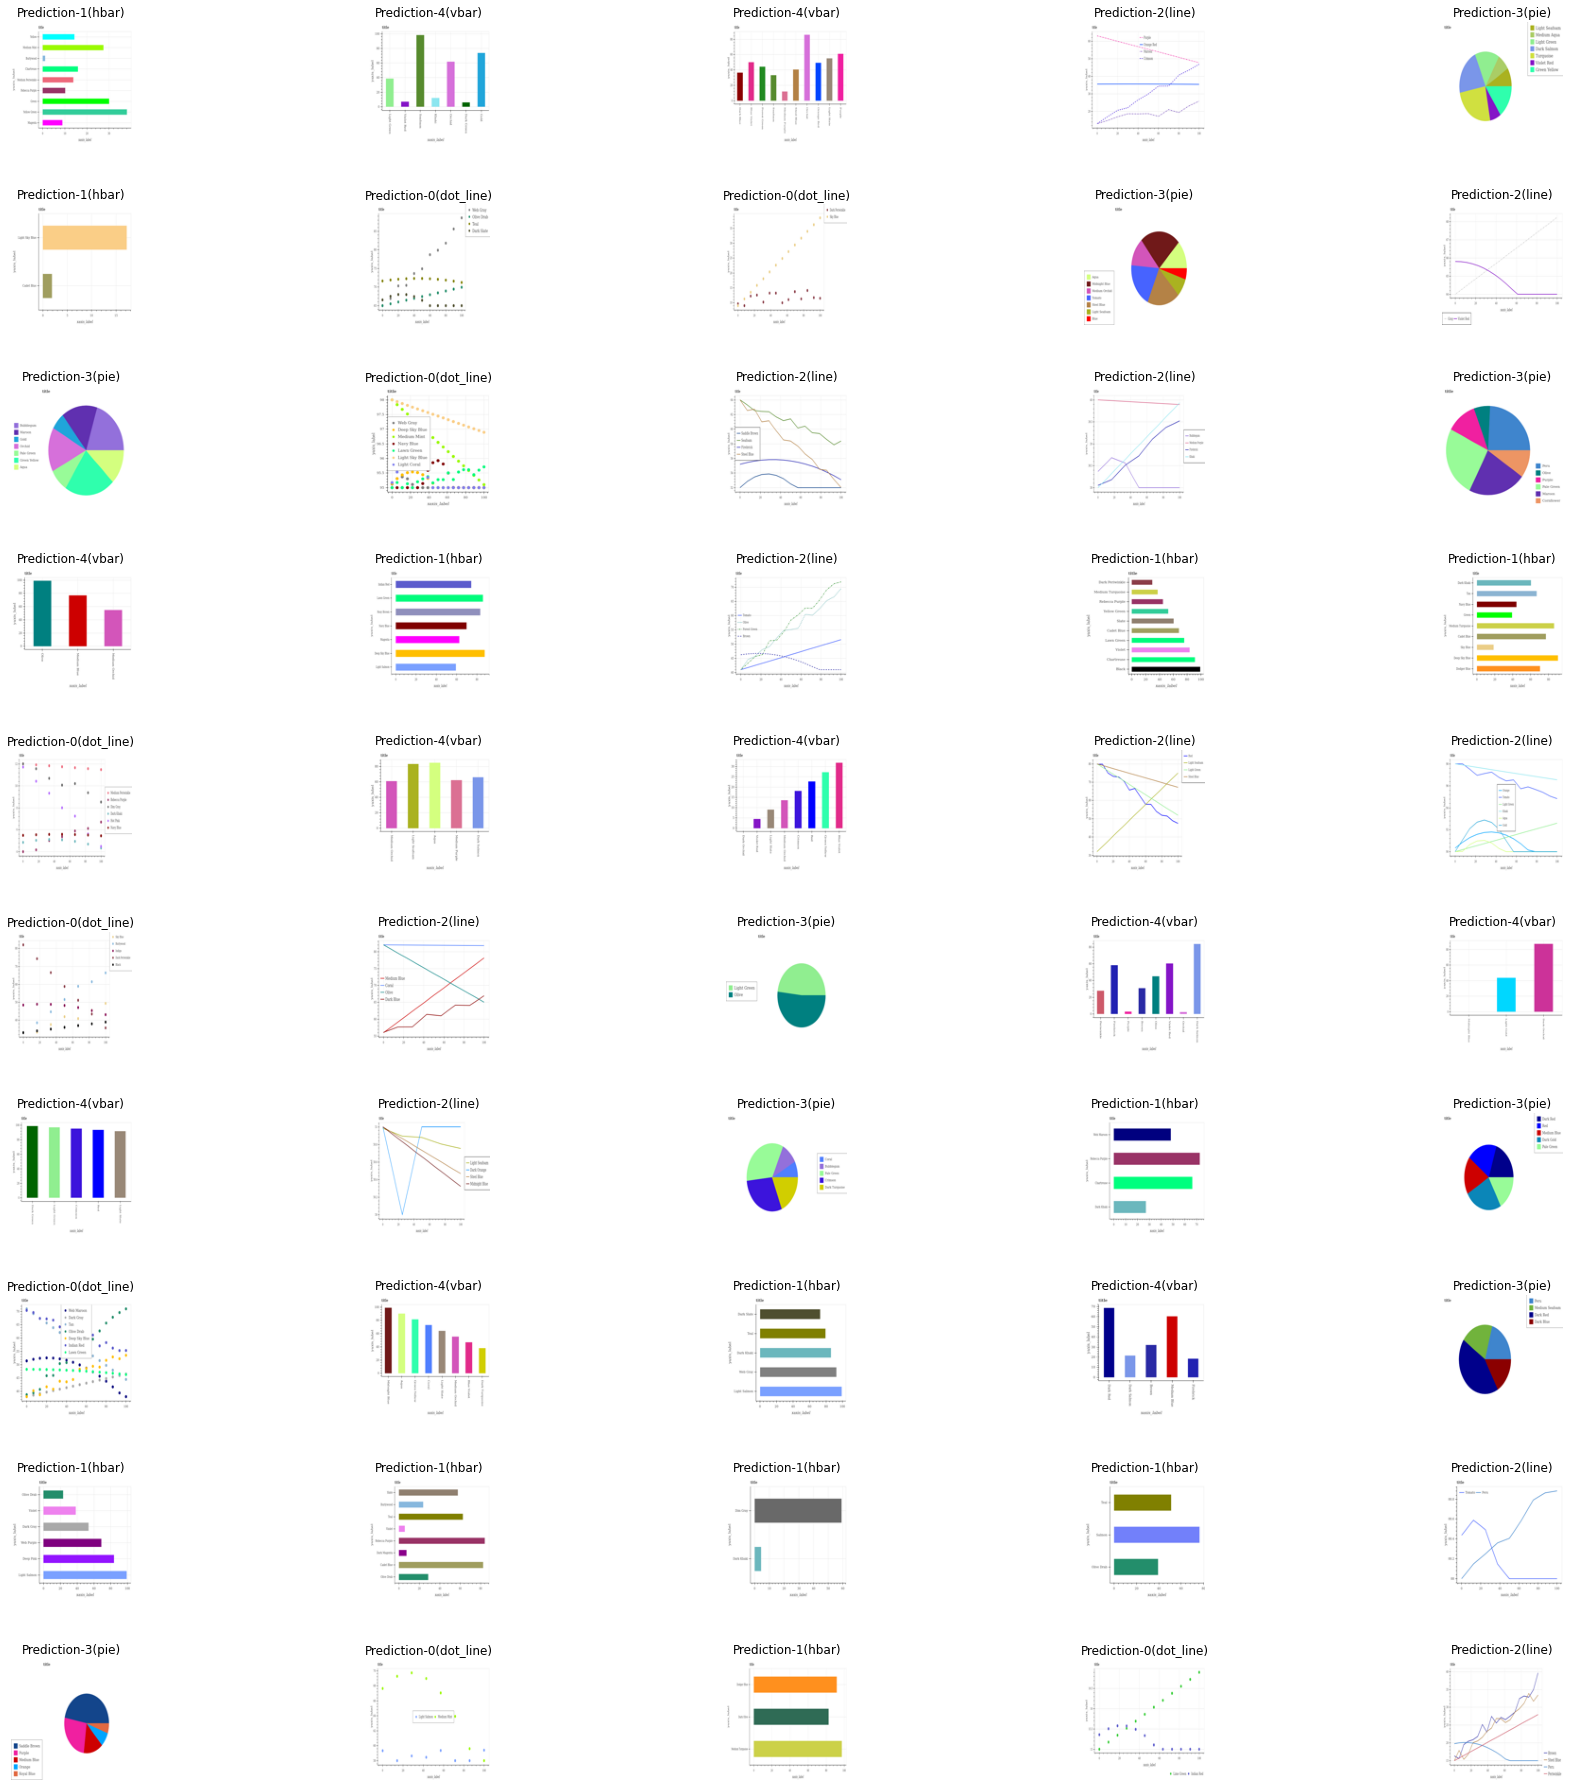

In [26]:
import numpy as np
prediction = model.predict(x_test)


fig, ax = plt.subplots(10, 5, figsize=(25,25))
fig.tight_layout(h_pad=4)
idx = 0
for i in range(0, 10):
    for j in range(0, 5):

        prediction_label = np.argmax(prediction[idx])
        ax[i][j].title.set_text('Prediction-{0}({1})'.format(prediction_label, Number(prediction_label).name))
        image = x_test[idx]
        ax[i][j].imshow(image)
        ax[i][j].axis("off")
        idx += 1 
plt.show()

## Evaluating the model on training set 

In [27]:
train_loss, train_acc = model.evaluate(x_train, y_train_enc)
print('Accuracy:', train_acc)
print('Loss: ', train_loss)

25/25 [==============================] - 3s 76ms/step - loss: 0.0063 - sparse_categorical_accuracy: 0.9987
Accuracy: 0.9987499713897705
Loss:  0.006279711611568928


confusion matrix on the predictions of training data

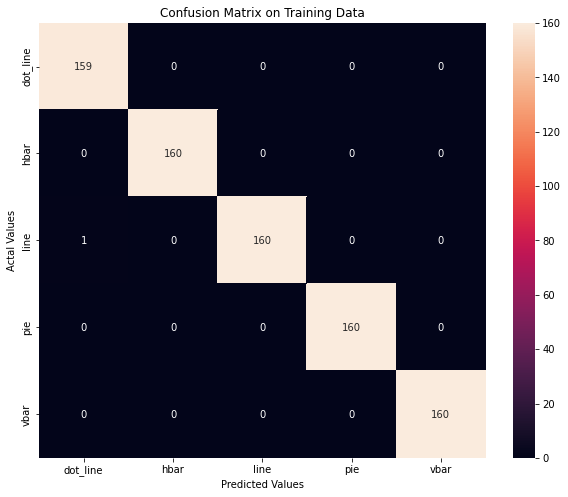

In [28]:
prediction = model.predict(x_train)
y_pred = [np.argmax(p) for p in prediction]

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, y_train_enc)

cm_df = pd.DataFrame(cm,
                     index = ['dot_line','hbar','line', 'pie', 'vbar'], 
                     columns = ['dot_line','hbar','line', 'pie', 'vbar'])

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix on Training Data')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Evaluating the model on validation set which is labelled

In [29]:
val_loss, val_acc = model.evaluate(x_validation, y_validation_enc)
print('Accuracy:', val_acc)
print('Loss: ', val_loss)

7/7 [==============================] - 2s 81ms/step - loss: 0.0789 - sparse_categorical_accuracy: 0.9700
Accuracy: 0.9700000286102295
Loss:  0.07891029119491577


confusion matrix for validation data

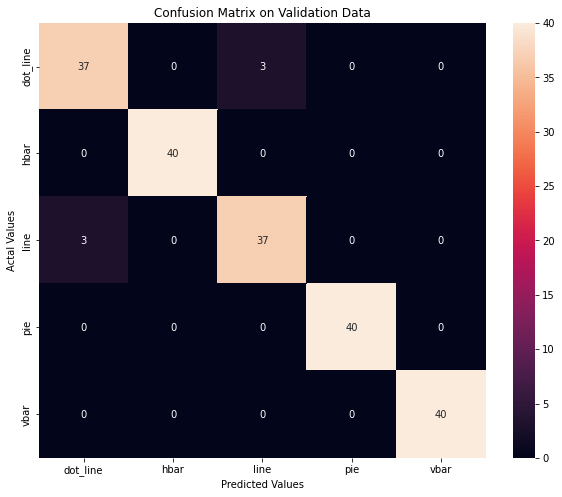

In [30]:
prediction = model.predict(x_validation)
y_pred = [np.argmax(p) for p in prediction]
cm = confusion_matrix(y_pred, y_validation_enc)

cm_df = pd.DataFrame(cm,
                     index = ['dot_line','hbar','line', 'pie', 'vbar'], 
                     columns = ['dot_line','hbar','line', 'pie', 'vbar'])

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix on Validation Data')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Visualizing the missclassified images

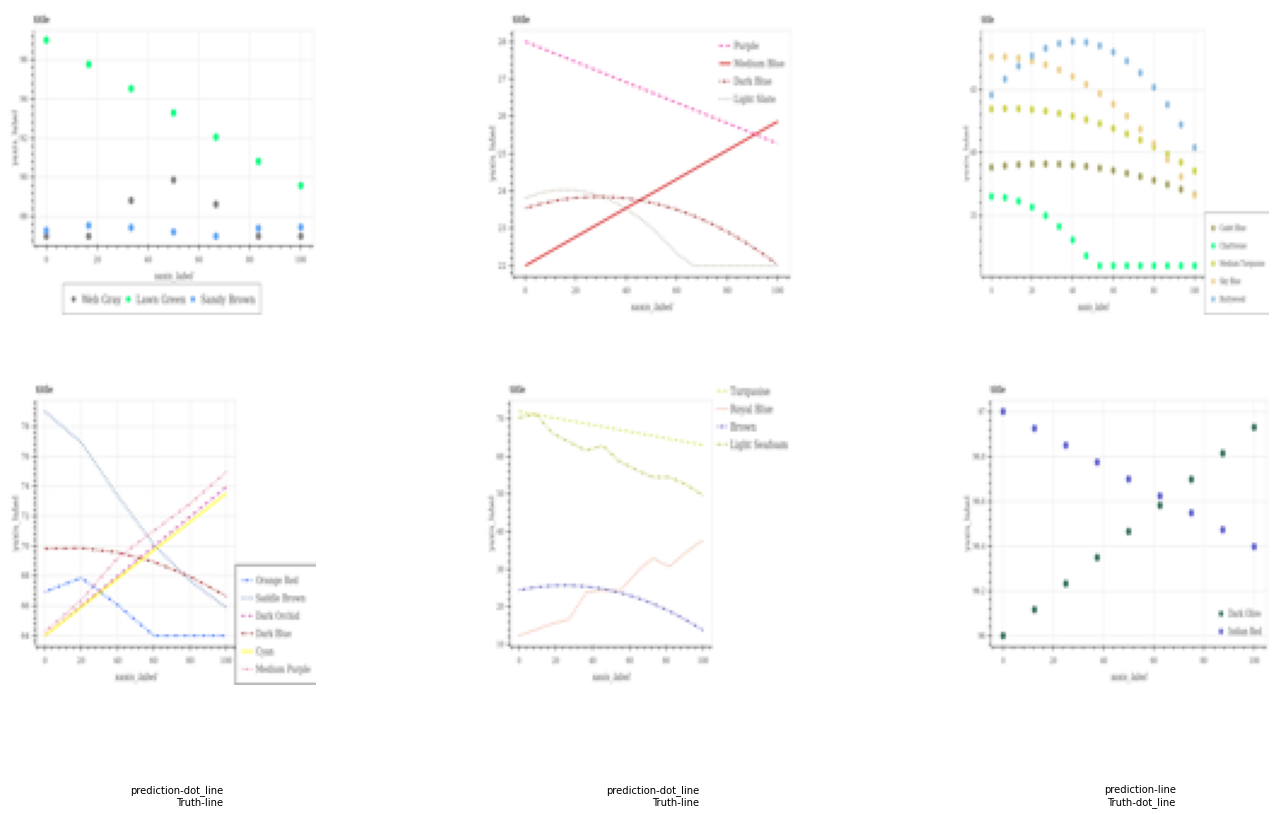

In [38]:
prediction = model.predict(x_validation)
y_pred = [np.argmax(p) for p in prediction]

indexs = [i for i in range(len(y_pred)) if y_pred[i]!=y_validation_enc[i]]


fig, ax = plt.subplots(2, 3, figsize=(20,10))
fig.tight_layout(h_pad=4)
idx = 0
for i in range(0, 2):
    for j in range(0, 3):

        prediction_label = np.argmax(prediction[indexs[idx]])
        ax[i][j].text(0.7, -0.4, "prediction-{0}\nTruth-{1}".format(Number(prediction_label).name, Number(y_validation_enc[indexs[idx]]).name),
          verticalalignment='bottom', horizontalalignment='right',
          transform=ax[i][j].transAxes, fontsize=10)
        image = x_validation[indexs[idx]]
        ax[i][j].imshow(image)
        ax[i][j].axis("off")
        idx += 1 

plt.savefig("/content/drive/MyDrive/charts/images/vit/wrong-Valprediction.png", bbox_inches='tight')
plt.show()